In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ML_utils import load_data,load_data_test_set, total_day_eve_night_grouping
df =pd.read_csv('train.csv')

### UNCOMMENT THIS PART TO GROUP FEATURES
feature_engineering = True
df=total_day_eve_night_grouping(df,grouping=feature_engineering)
exclude_list = [feature_name for feature_name in df.columns if feature_name not in['number_vmail_messages','number_customer_service_calls','churn']]
one_hot_on = True
normalize_on = True
oversample_on=True


###################
#### LOAD DATA ####

X_train,y_train,X_val,y_val,X_test,y_test,columns = load_data(df,exclude=exclude_list,one_hot=one_hot_on,normalize_=normalize_on,oversample=oversample_on)


X_train.shape
X_train

array([[ 2.,  0.],
       [ 1., -1.],
       [ 0.,  2.],
       ...,
       [ 0.,  0.],
       [ 0., -1.],
       [ 0., -1.]], dtype=float32)

ValueError: x and y must be the same size

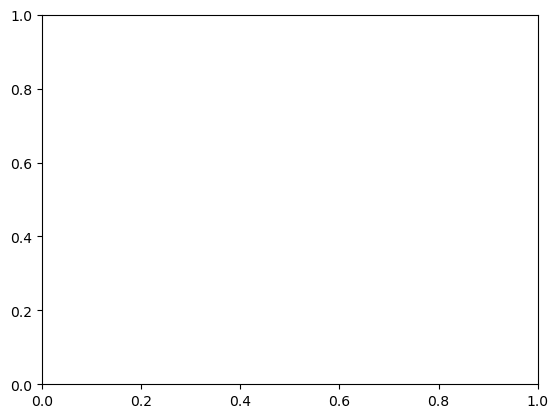

In [38]:
plt.scatter(X_train[:,0],np.zeros(X_train.shape[0]),c=['red' if y_train[i] == 1 else 'blue' for i in range(len(y_train))])

plt.xlabel('number_vmail_messages')


In [24]:
def svm(x_train,y_train,lr=0.01,epochs=1000,batch_size=32):
    w=np.zeros(x_train.shape[1])
    lr=1
    epoch=10000
    out=[]
    
    for i in range(epoch):
        for i in range(x_train.shape[0]):
            x=x_train[i]
            y=y_train[i]
            val1=np.dot(w,x)
        
            if y*val1<1:
                w=w+lr*((y*x)-2*(1/epoch)*w)
            else:
                w=w+lr*(-2*(1/epoch)*w)
                
    return w
    

In [25]:
# def svm_function(x,y):
#     w= np.zeros(x.shape[1])
#     lr=0.1
#     epoch=10000
#     out=[]
#     for e in range(epoch):
#         for i, val in enumerate(x):
#             val1=np.dot(x[i],w)
#             if (y[i]*val1<1):
#                 w=w+lr*((y[i]*x[i])-2*(1/epoch)*w)
#             else:
#                 w=w+lr*(-2*(1/epoch)*w)
                
#     for i, val in enumerate(x):
#         out.append(np.dot(x[i],w))
        
#     return w,out


# w,out=svm_function(X_train,y_train)

w=svm(X_train,y_train)
            
            

In [26]:

from sklearn.metrics import accuracy_score

def predict(x,w):
    out = np.dot(x,w)
    return out

y_pred = predict(X_val,w)
print(y_pred)
y_pred=np.sign(y_pred)
print(y_pred)
y_pred = np.where(y_pred>0,1,0)
accuracy_score(y_val,y_pred)

[ 2.50256001e+00 -3.87568528e+00  8.30760480e-01 -1.28988118e+01
  4.26445031e+00 -7.33509807e-01 -7.65889862e-01  1.66562541e+00
 -2.17252714e+00 -8.70715475e+00  1.39545708e+00 -4.16067688e+00
  1.16647862e+00  1.58633688e+00 -1.01327885e+01 -6.36601567e-01
 -1.06216786e+01 -1.71433840e+00  2.05913150e+00  3.14853750e+00
 -4.62459903e+00 -1.11871097e+01  3.97372564e+00 -2.96827196e+00
  7.70608325e+00  5.35687022e+00 -4.51594943e-01 -2.16966804e+00
  5.08662482e+00  1.24259886e+00 -7.29243425e+00  2.51121530e+00
 -1.64695110e+00 -6.26435395e+00  4.07364770e+00  3.27774844e+00
  2.53047379e+01  9.66480391e+00 -8.03158624e+00 -1.77314801e+00
  1.41601334e+00 -6.45637326e+00 -7.58616577e+00 -8.48115068e-01
  1.19303231e-01 -6.71918301e-01  1.35728109e+00  6.90145136e+00
  5.53013040e+00 -5.39986495e+00 -4.39960500e+00  4.93979412e+00
  1.29861129e+01 -1.00194077e+01 -2.28612536e+00  1.14474046e+01
  4.87534319e+00  6.78120471e+00 -4.74206330e+00 -3.59951109e+00
 -4.62179480e+00  4.36723

0.5525902668759811